#Welcome

In this notebook I will be training various machine learning models to perform classification. I will be working with a dataset where features are information about patients and the dependant variable is information if they have heart disease

Below is a short description of every feature

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal] 


In [ ]:
!pip install plotly --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 21.5 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 300 (delta 74), reused 99 (delta 55), pack-reused 171
Receiving objects: 100% (300/300), 87.58 KiB | 14.60 MiB/s, done.
Resolving deltas: 100% (136/136), done.
Traceback (most recent call last):
  File "rapidsai-csp-utils/colab/env-check.py", line 1, in <module>
    import pynvml
ModuleNotFoundError: No module named 'pynvml'


In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL,
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
import cuml
from cuml.pipeline import Pipeline as Pipeline
from cuml.model_selection import GridSearchCV
from cuml.svm import SVC
from cuml.neighbors import KNeighborsClassifier
from cuml import LogisticRegression

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline as Pipeline_sk
from sklearn.neighbors import KNeighborsClassifier as KNN_sk

In [ ]:
import joblib
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle_datasets/heart.csv')

Lets start with exploring and visualizing the data

There are no null values but that doesn't mean there are no missing values, they might be '?' strings or something similar

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Dataset is pretty balanced which is good

In [ ]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [ ]:
df.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


In [ ]:
X = df.drop('HeartDisease', axis=1)

In [ ]:
categorical_features, numerical_features = [], []
for colname, dtype in zip(X.columns, X.dtypes):
  if dtype == 'object':
    categorical_features.append(colname)
  else:
    numerical_features.append(colname)


Let's plot histograms and box plots for numerical columns and histograms for categorical columns

In [ ]:
for colname in numerical_features:
    fig = make_subplots(rows=1, cols=2, subplot_titles=(f'{colname} distribiution', f'{colname} boxplot'))
    fig.add_trace(go.Histogram(x=df[colname], nbinsx=15), row=1, col=1)
    fig.add_trace(go.Box(x=df[colname]), row=1, col=2)
    fig.show()



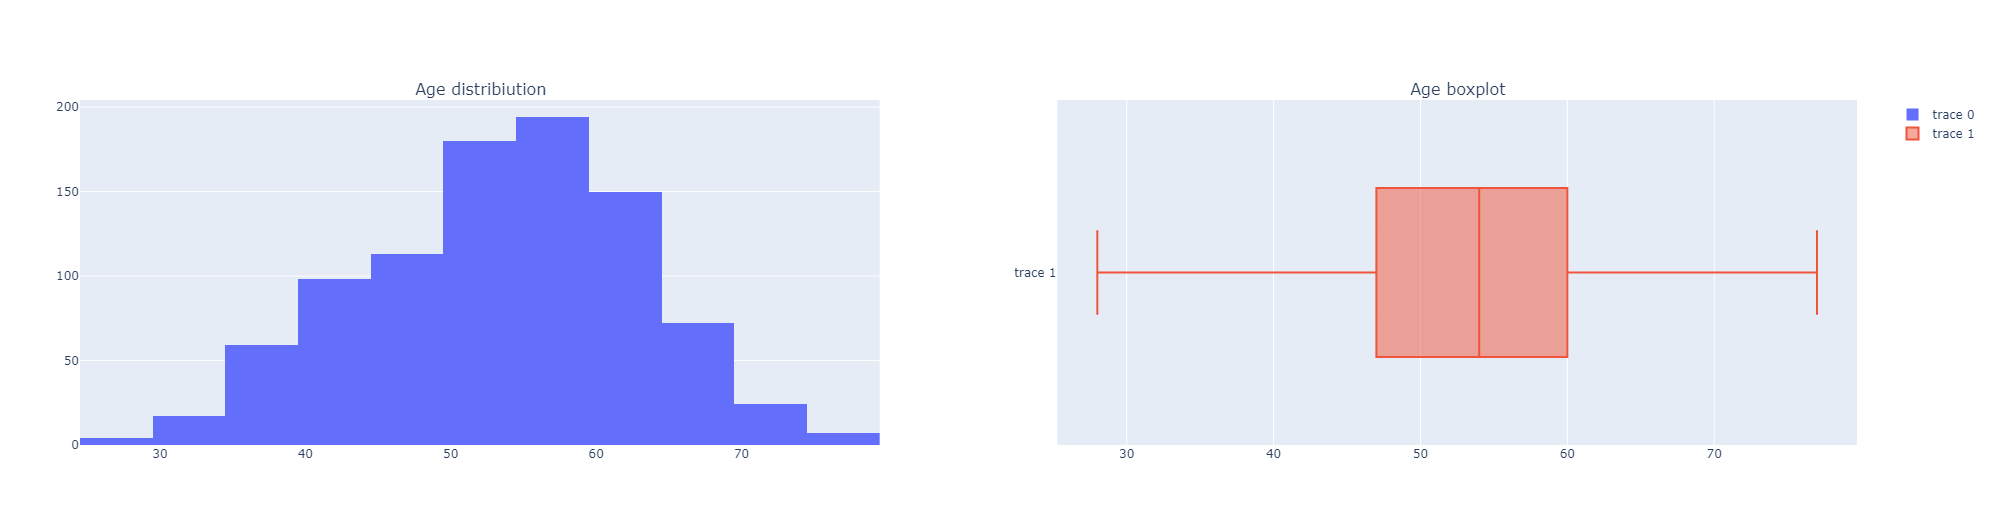

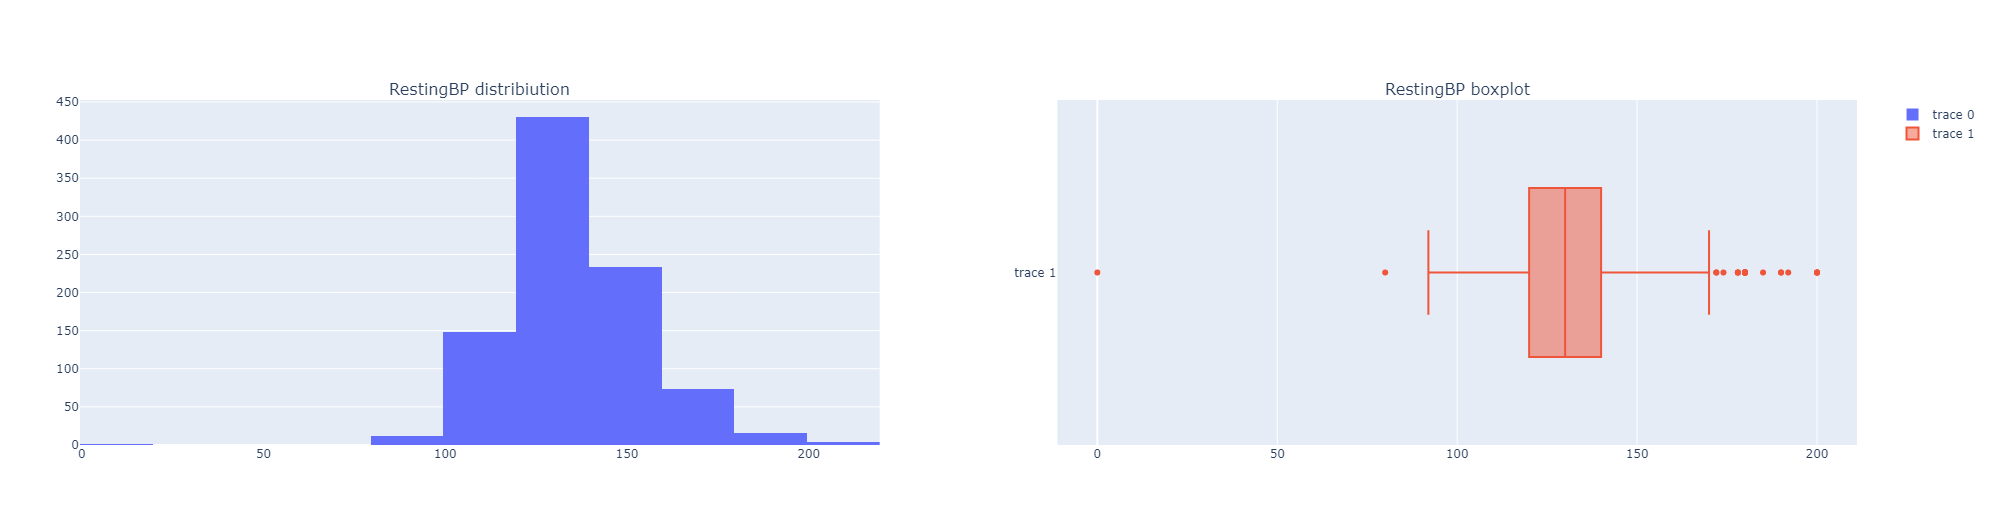

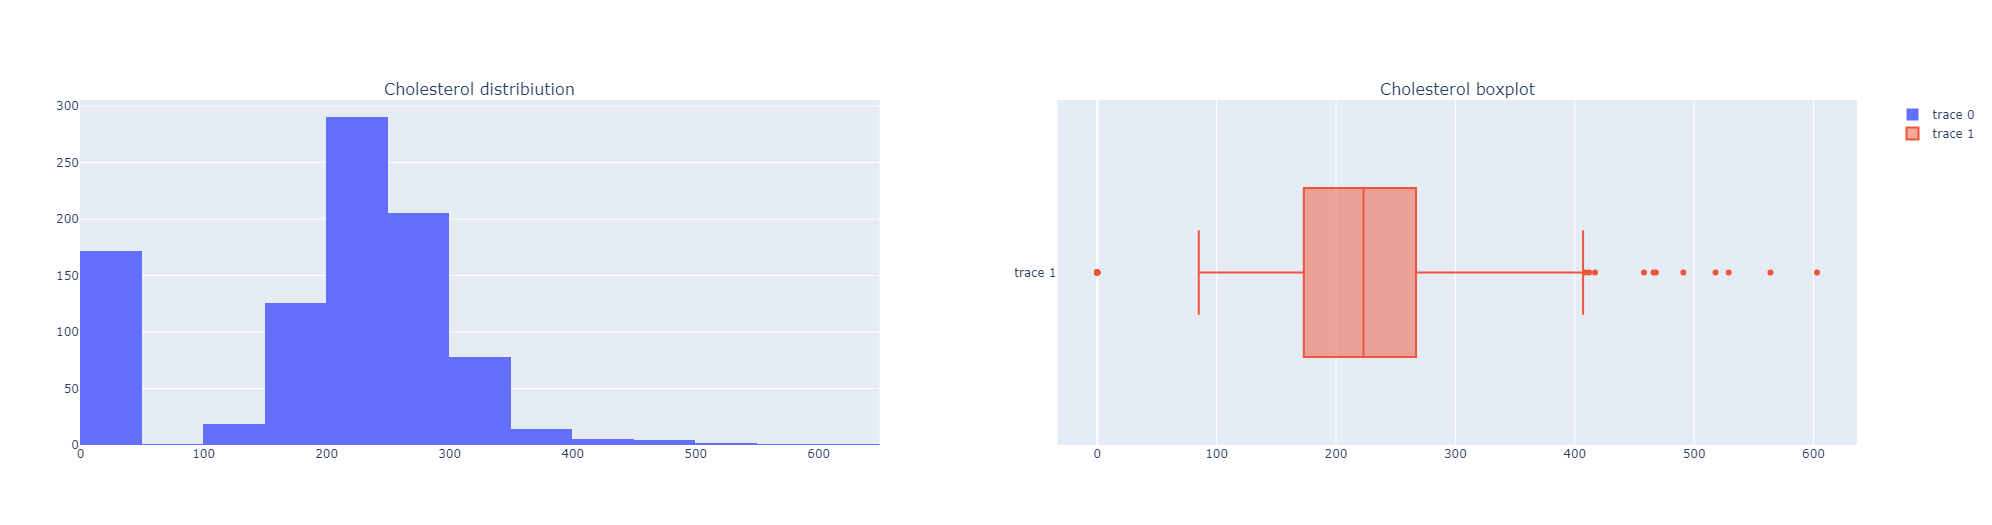

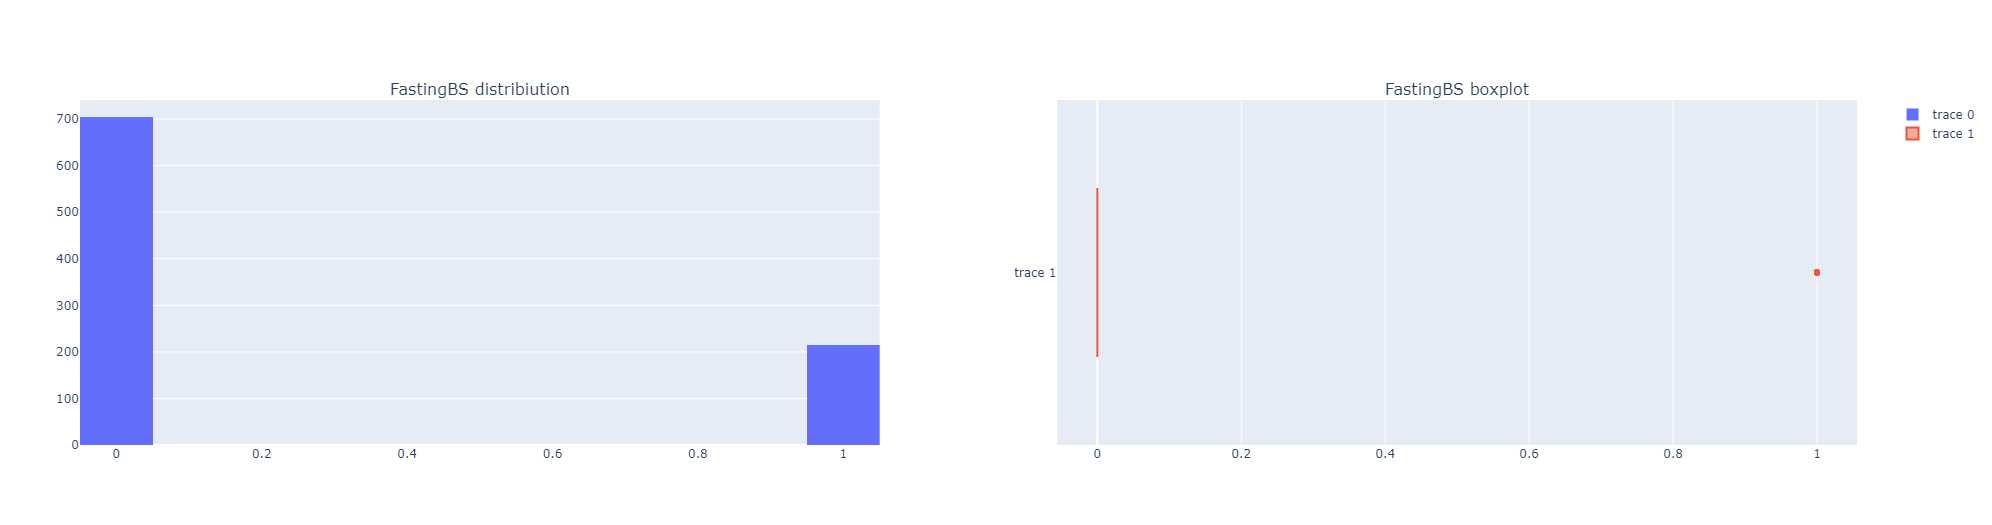

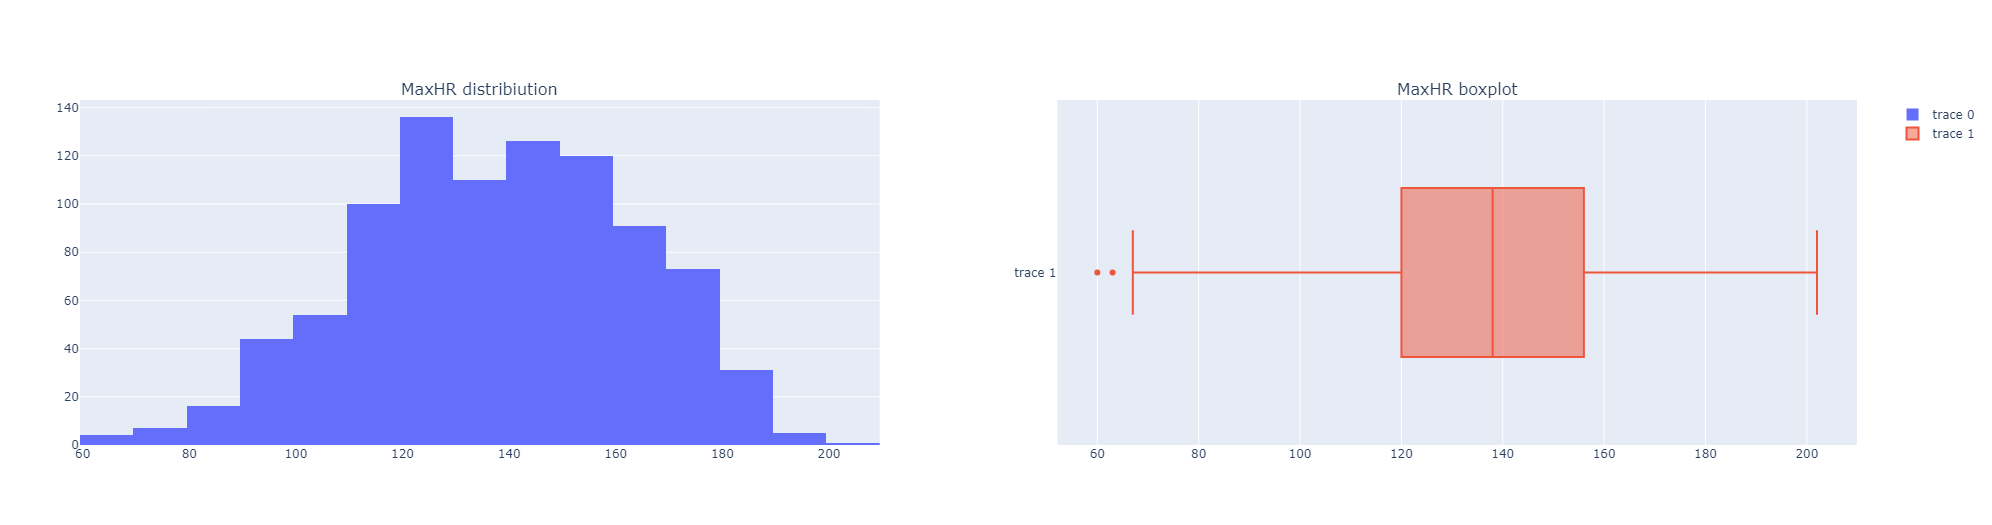

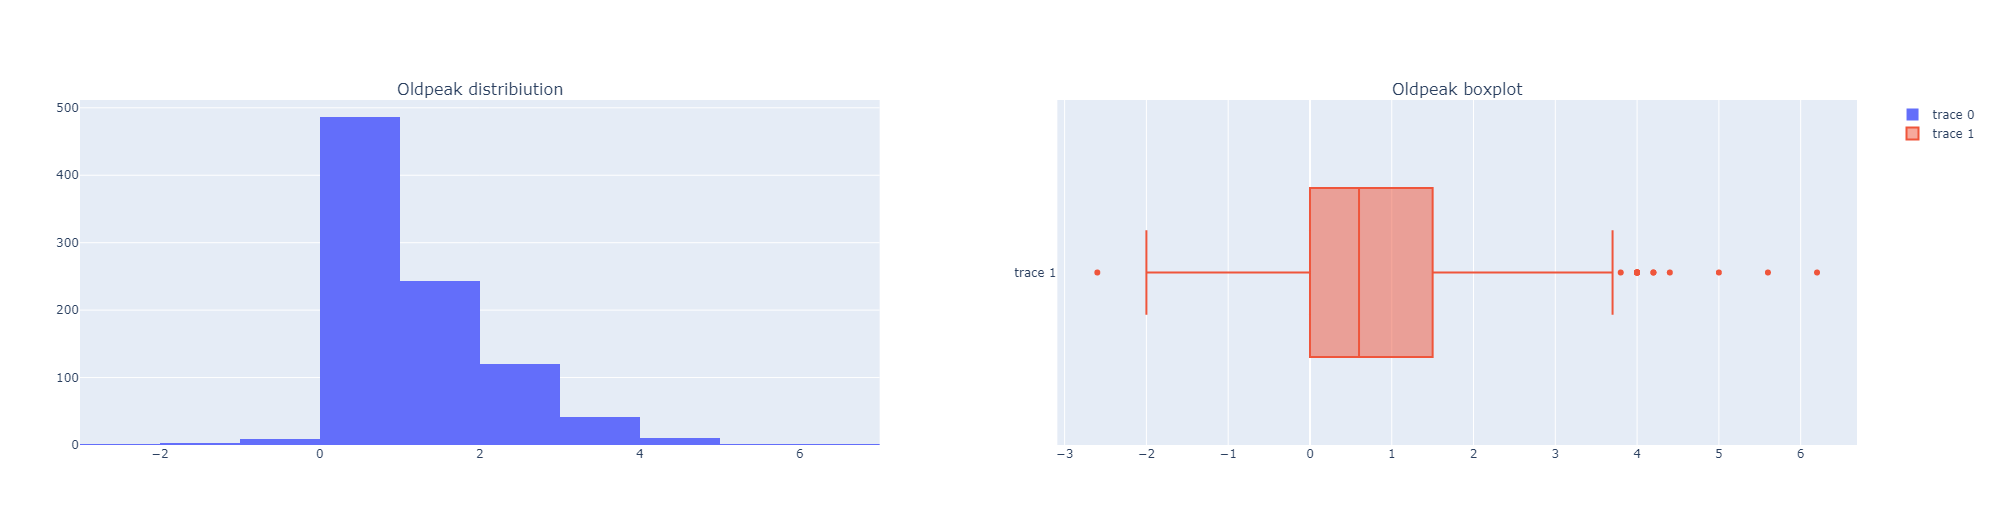

In [ ]:
for colname in categorical_features:
  fig = px.histogram(df, colname, nbins=15)
  fig.show()

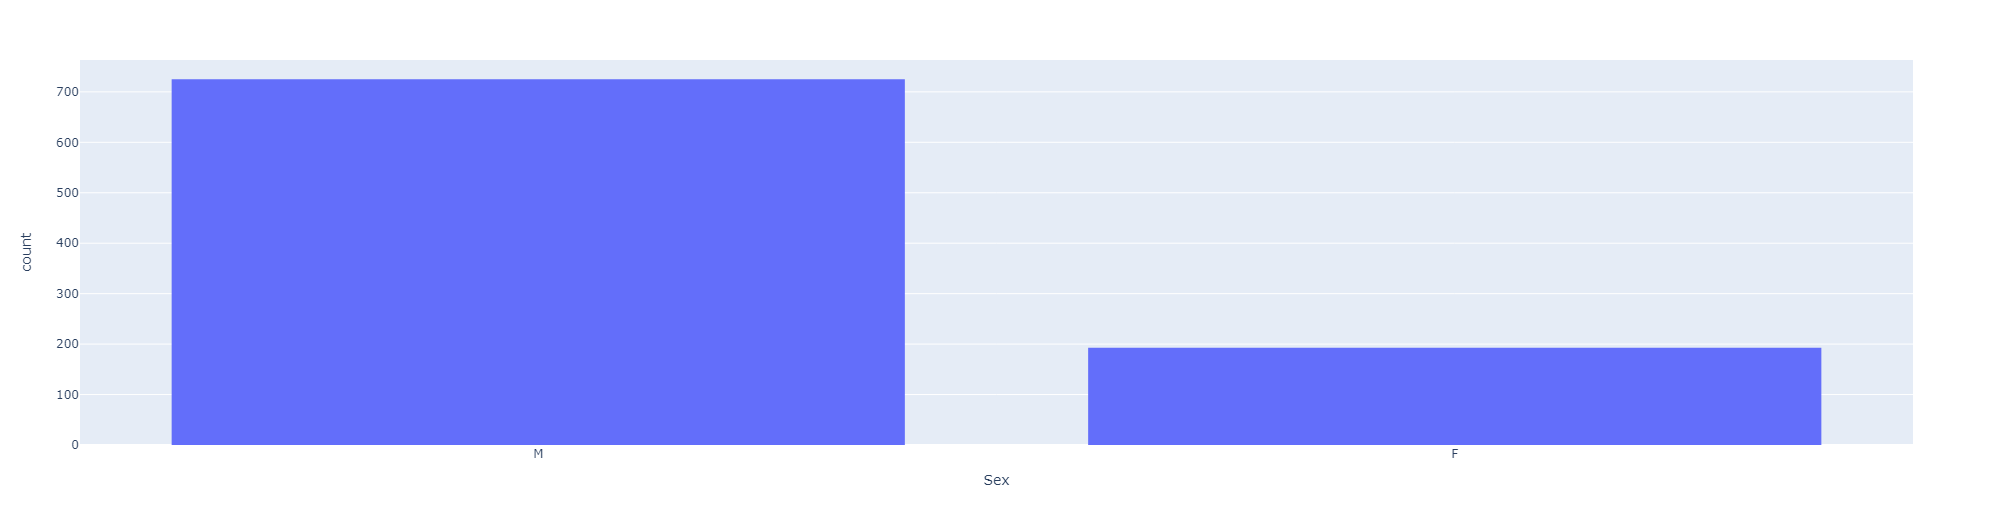

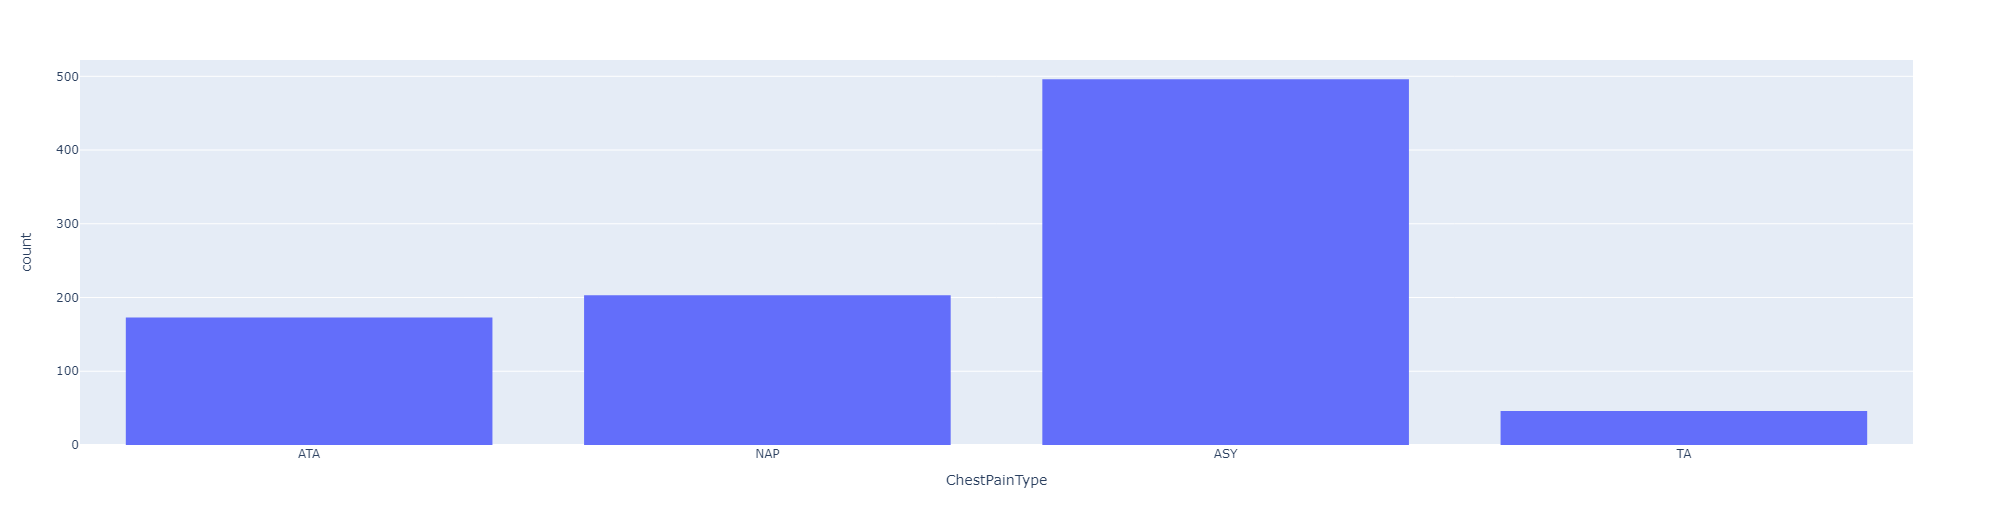

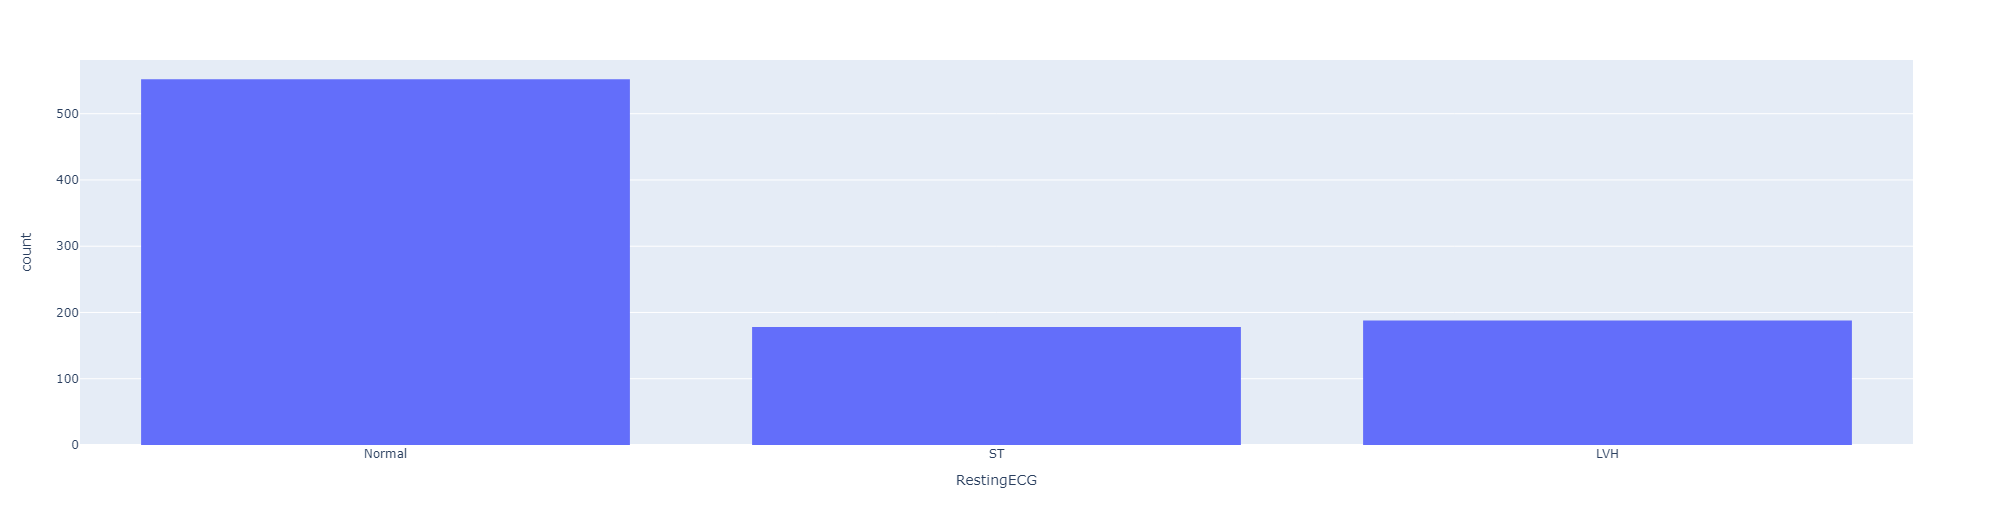

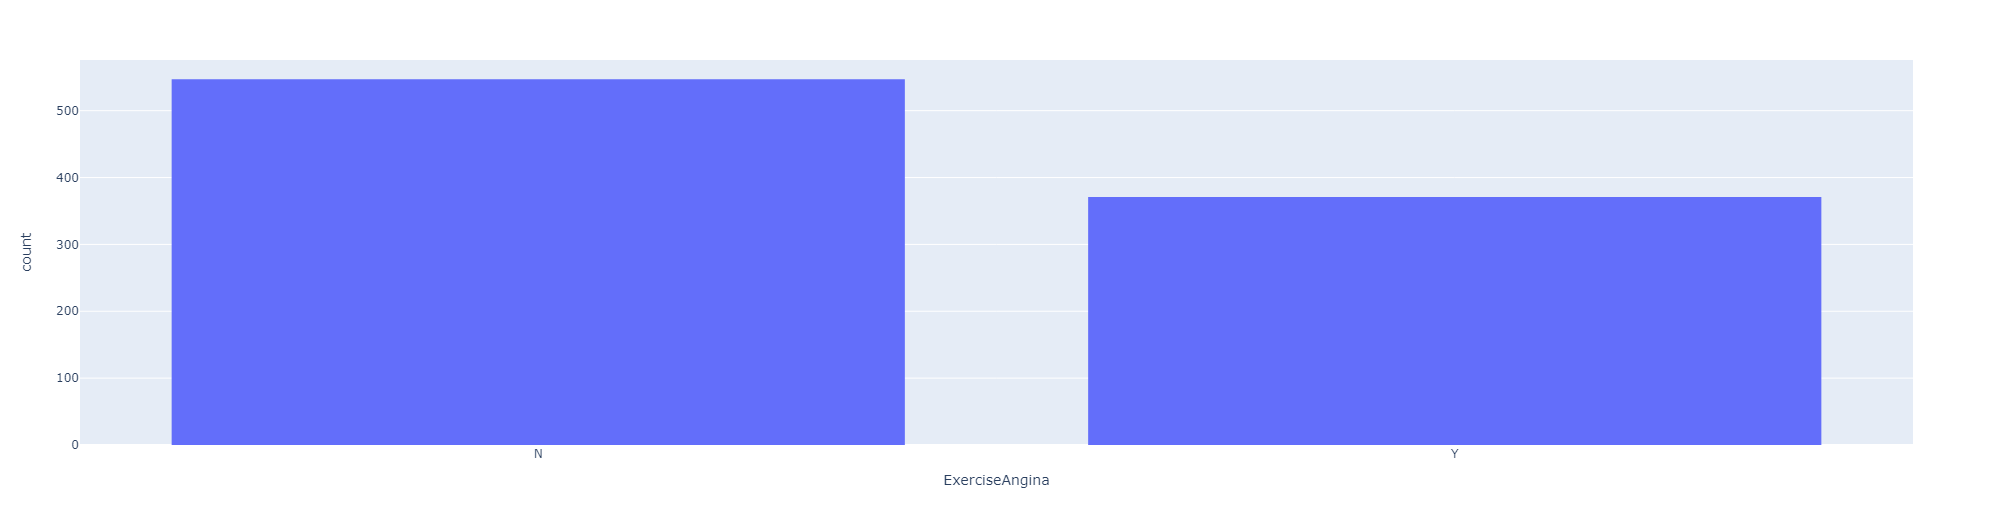

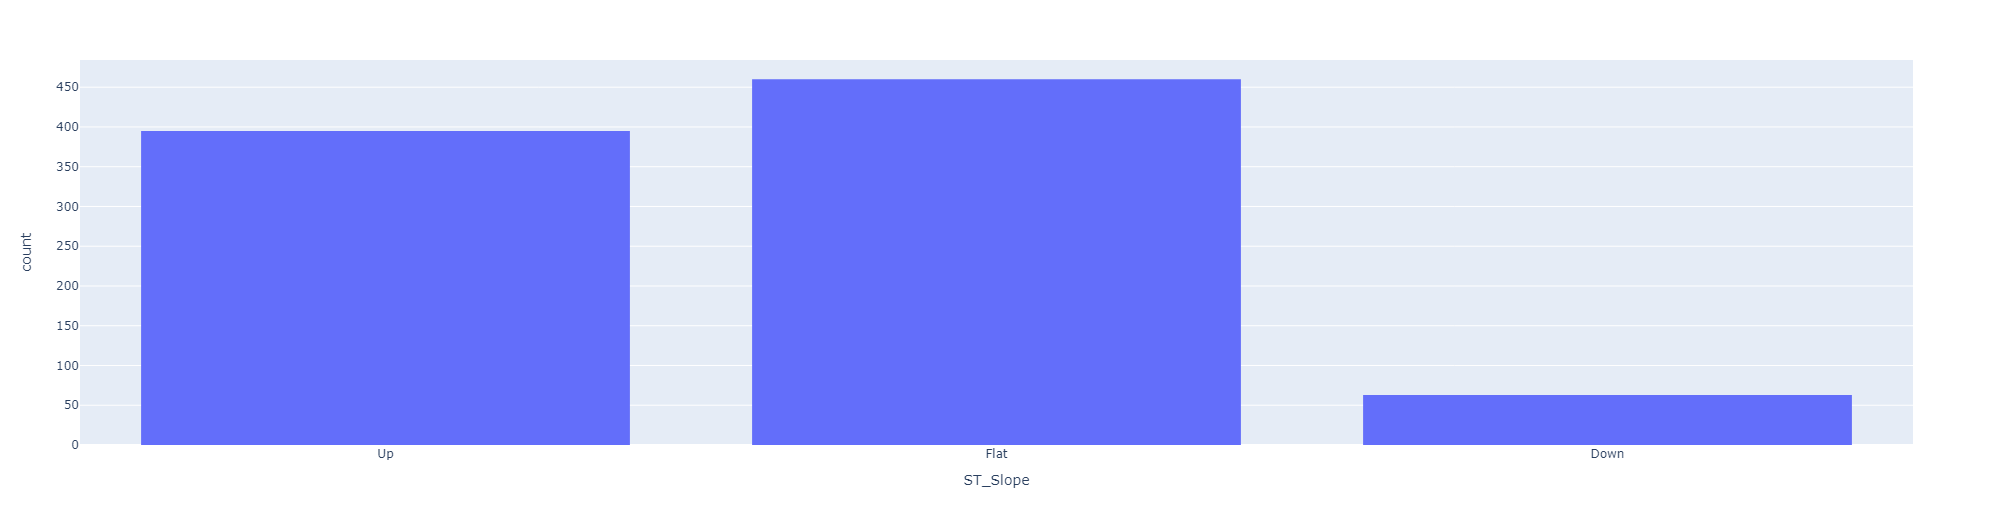

After looking through histograms of particular columns cholersterol distribiution looks suspicious so let's investigate that.

There are also some outliers if we consider points outside of boxplot upper and lower fences outliers. I have no domain knowledge so I'm not going to further investigate that matter.

I have accidentally classified FastingBS as numerical feature when in fact it is a categorical feature with numerical values. It has only two unique values which makes it a dummy variable. Turns out it's good that FastingBS got classified as numerical feature as I'm going to use list of categorical features to select them for one hot encoding and FastingBS already is one hot encoded.

In [ ]:
len(df[df['Cholesterol'] == 0])

172

In [ ]:
len(df[df['Cholesterol'] == 0])/len(df) * 100

18.736383442265794

Almost 19% of the data has 0 in the cholesterol column. These 0 indicate missing values rather than actual mesurements which results were 0. I'll change these zeros to np.nans and they will later be imputed using iterative imputer.

In [ ]:
df['Cholesterol'] = df['Cholesterol'].map(lambda x: np.nan if x == 0 else x)

In [ ]:
df[df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


There is another case of 0 being put in instead of np.nan for 1 row in RestingBP column. I'm going to drop this row.

In [ ]:
df = df[df['RestingBP'] != 0] 

I'm going to start with Logistic Regression as my estimator. I'll be imputing missing values with iterative imputer. I'll combine all preprocessing steps with estimator using a pipeline. I will perform hyperparameter tuning with GridSearchCV. For grid search I'm going to use 5 fold stratified cross validation. As scoring metric I chose accuracy. In case of predicting heart disease false negatives are the most 'expensive'. Metric that takes false negatives into account is recall of class 1 also called sensitivity but if I would have chosen recall as scoring metric best models returned by grid search would be the ones classyfing every sample as 0 as it would maximize recall of class 0. Another problem is that in sklearn when scoring is set to recall it computes recall of class 0, I could solve this problem by swapping class labels.

In [ ]:
ct_one_hot = ColumnTransformer([
    ('one_hot', OneHotEncoder(sparse=False), categorical_features)
], remainder='passthrough')

In [ ]:
lr_imp = LinearRegression()
imp = IterativeImputer(estimator=lr_imp, verbose=0, max_iter=20, tol=1e-7)

In [ ]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [ ]:
logreg = LogisticRegression()

In [ ]:
log_pipe = Pipeline([
                     ('ct_one_hot', ct_one_hot),
                     ('scaler', StandardScaler()),
                     ('imputer', imp),
                     ('LogReg', logreg)
])

In [ ]:
parameters = {
    'LogReg__penalty':['elasticnet'],
    'LogReg__C':[0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 5, 10],
    'LogReg__fit_intercept':[True, False],
    'LogReg__l1_ratio':[0, 0.25, 0.5, 0.75, 1]
}

In [ ]:
log_grid_pipe = GridSearchCV(log_pipe, param_grid=parameters, scoring='accuracy', cv=5, verbose=2)

In [ ]:
log_grid_pipe.fit(X, y)

In [ ]:
log_grid_pipe.best_score_

0.8451176051318603

In [ ]:
log_grid_pipe.best_params_

{'LogReg__C': 0.5,
 'LogReg__fit_intercept': False,
 'LogReg__l1_ratio': 0,
 'LogReg__penalty': 'elasticnet'}

Grid search selected C to be 0.5 and L1 ration to be 0 so the best solution is achieved with some L2 reguralization.


In order to visualize model's predictions I'm going to use a function that returns confusion matrix with predictions from 5 cv folds. These 5 folds are identical as these used in grid search.

In [ ]:
def recall_class_1(confusion_matrix):
  return confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])

In [ ]:
def get_cm_and_recall(pipeline, best_params_grid, n_splits=5):
  '''
  Returns confusion matrix averaged over n cv folds and recall scores for every fold

  Parameters should be passed as dictionary returned from gridsearchcv method best_params_
  '''
  skf = StratifiedKFold(n_splits=5)
  skf.get_n_splits(X, y)
  cm = np.zeros([2, 2])
  recall, index = [], []
  pipeline.set_params(**best_params_grid)
  i = 0
  for train_index, test_index in skf.split(X, y):
      X_train, y_train = X.iloc[train_index], y.iloc[train_index]
      X_test, y_test = X.iloc[test_index], y.iloc[test_index]
      pipeline.fit(X_train, y_train)
      preds = pipeline.predict(X_test)
      temp_cm = confusion_matrix(y_test, preds)
      cm += temp_cm
      recall.append(recall_class_1(temp_cm))
      index.append(f'split{i}_recall_score')
      i += 1
  cm = cm 
  recall.append(np.mean(recall))
  recall.append(np.std(recall[:5]))
  index.append('mean_recall_score')
  index.append('std_recall_score')
  recall = pd.DataFrame(recall, index=index)
  return cm, np.round(recall*100, 2)

In [ ]:
def display_cm(cm):
  fig = px.imshow(cm, text_auto=True,
                  x=['0', '1'], y=['0', '1'],
                  color_continuous_scale='deep',
                  labels=dict(x='Predicted Label', y='True Label'))
  

  return fig

In [ ]:
cm, recall = get_cm_and_recall(log_pipe, log_grid_pipe.best_params_)

In [ ]:
recall

,0
split0_recall_score,84.31
split1_recall_score,77.45
split2_recall_score,97.03
split3_recall_score,91.09
split4_recall_score,70.30
mean_recall_score,84.04
std_recall_score,9.50


In [ ]:
fig = display_cm(cm)
fig.show()

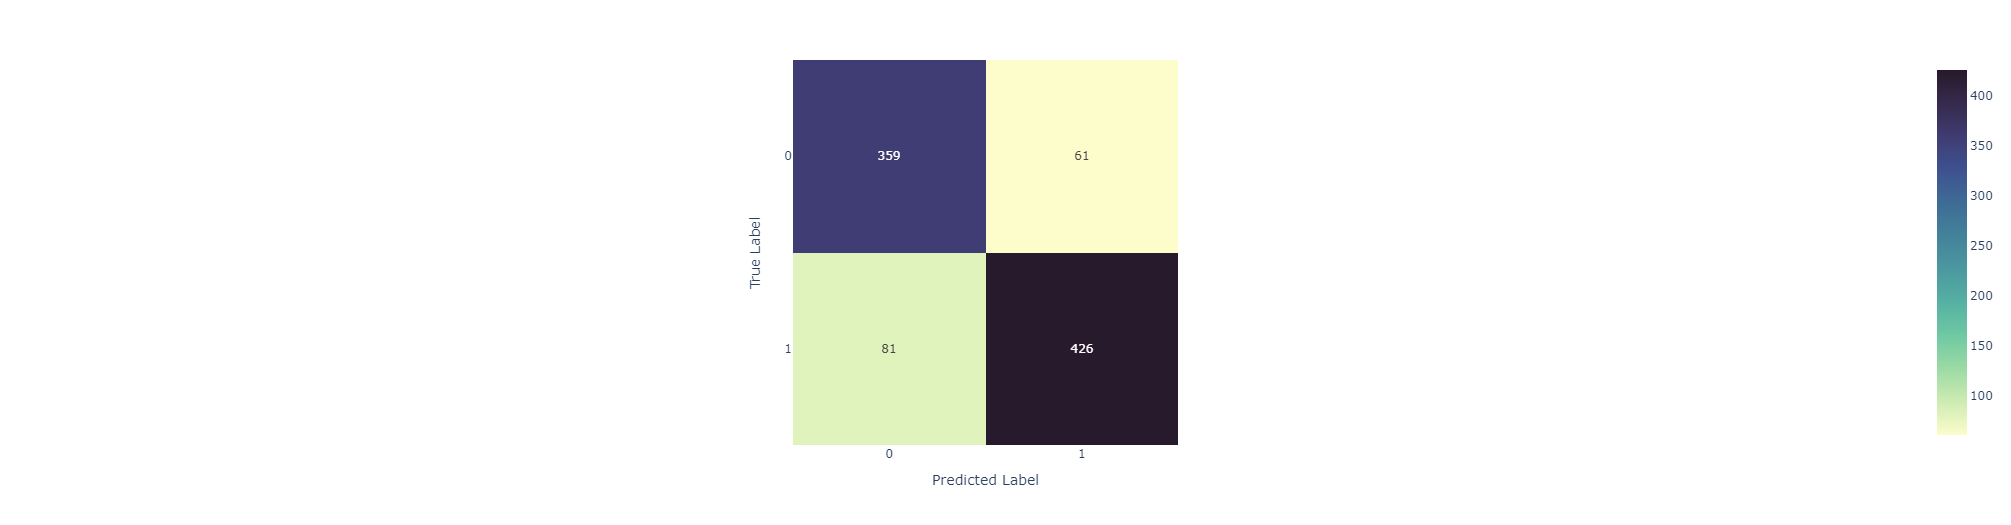

In [ ]:
recall_class_1(cm)

0.8402366863905325

In [ ]:
def get_results(grid_object, recall):
  results_common_cols = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score']
  params = pd.DataFrame(grid_object.cv_results_).loc[grid_object.best_index_]['params']
  results = pd.DataFrame(grid_object.cv_results_)
  results = pd.DataFrame(results.loc[grid_object.best_index_])
  results.columns = [grid_object.estimator.steps[-1][0]]
  results = results.loc[results_common_cols]
  results = np.round(results*100, 2)
  recall.columns = [grid_object.estimator.steps[-1][0]]
  results = pd.concat([results, recall], axis=0)
  results = pd.concat([results, pd.DataFrame({grid_object.estimator.steps[-1][0]: [params]}, index=['params'])])
  return results

In [ ]:
results = get_results(log_grid_pipe, recall)

As you can see Logistic Regression is able to achieve mean accuracy of 84.5% with standard deviation 4.6% and  84% recall with std of 9.5%

In [ ]:
results

,LogReg
split0_test_score,88.043478
split1_test_score,83.695652
split2_test_score,86.338798
split3_test_score,88.52459
split4_test_score,75.956284
mean_test_score,84.511761
std_test_score,4.599481
split0_recall_score,84.31
split1_recall_score,77.45
split2_recall_score,97.03


Next up I'll train XGBoost classifier 

Tree based methods doesn't require data to be scaled to produce good results so I'm not using any scaler.

In [ ]:
pipe_xgbc = Pipeline([
          ('column_transformer', ct_one_hot),
          ('imputer', imp),
          ('XGBC', XGBClassifier())                      
])

In [ ]:
parameters = {
    'XGBC__learning_rate':[0.1, 0.2, 0.3],
    'XGBC__max_depth':[6, 9, 15],
    'XGBC__gamma':[0, 1, 10, 100],
    'XGBC__reg_lambda':[0, 1, 5, 10],
    'XGBC__tree_method':['gpu_hist'],
    'XGBC__subsample':[0.7, 1],
    "XGBC__use_label_encoder":[False],
    'XGBC__min_child_weight':[1, 10, 20]
}

In [ ]:
XGBC_grid_pipe = GridSearchCV(pipe_xgbc, parameters, scoring='accuracy', cv=3, verbose=2)

In [ ]:
XGBC_grid_pipe.fit(X, y)

In [ ]:
XGBC_grid_pipe.best_score_

0.8505339476409871

In [ ]:
XGBC_grid_pipe.best_params_

{'XGBC__gamma': 0,
 'XGBC__learning_rate': 0.2,
 'XGBC__max_depth': 6,
 'XGBC__min_child_weight': 10,
 'XGBC__reg_lambda': 5,
 'XGBC__subsample': 1,
 'XGBC__tree_method': 'gpu_hist',
 'XGBC__use_label_encoder': False}

After first grid search mean accuracy and recall improved comparing to logistic regression. I'm going to do another grid search narrowing down the range of candidate values.

In [ ]:
cm, recall0 = get_cm_and_recall(pipe_xgbc, XGBC_grid_pipe.best_params_)

In [ ]:
fig = display_cm(cm)
fig.show()

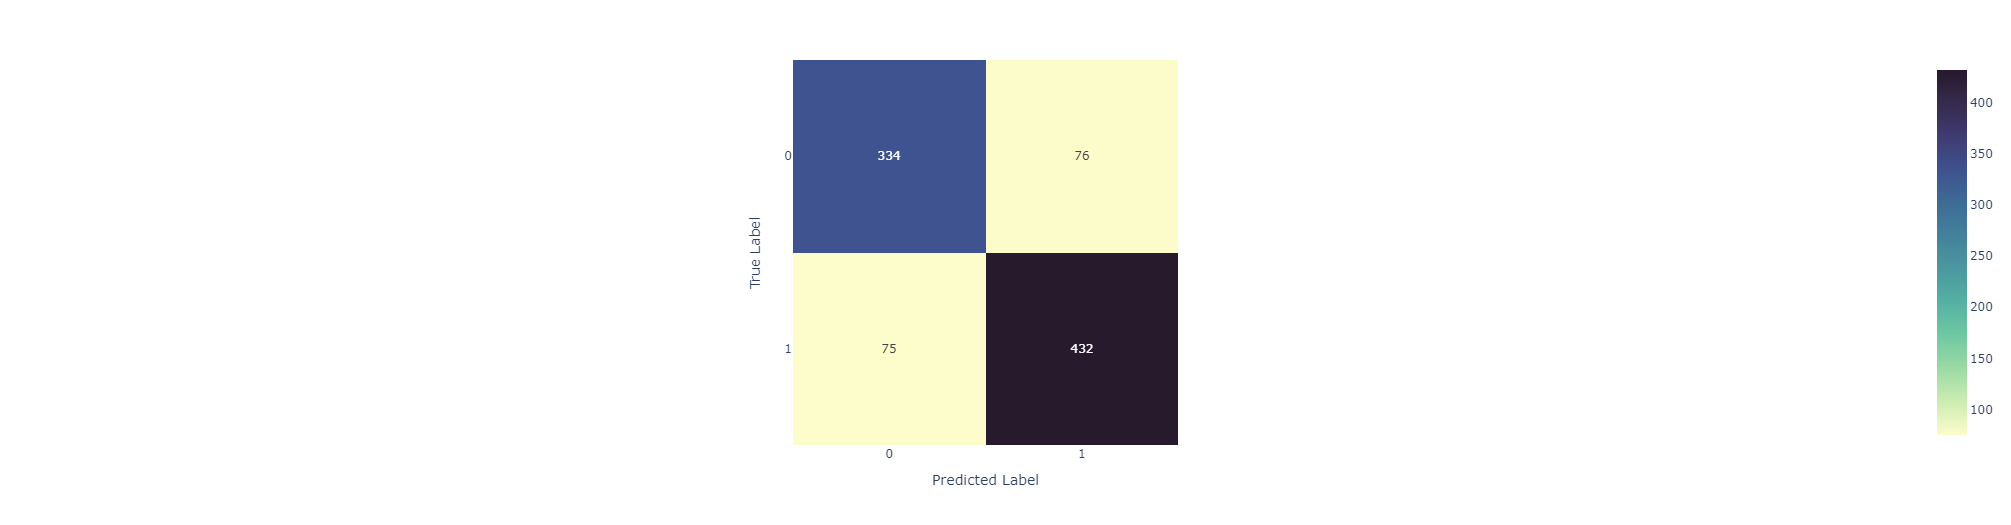

In [ ]:
recall0

,0
split0_recall_score,88.24
split1_recall_score,79.41
split2_recall_score,97.03
split3_recall_score,90.10
split4_recall_score,71.29
mean_recall_score,85.21
std_recall_score,8.95


In [ ]:
parameters = {
    'XGBC__learning_rate':[0.15, 0.2, 0.25],
    'XGBC__max_depth':[6, 9],
    'XGBC__gamma':[0],
    'XGBC__reg_lambda':[3, 4, 5, 6, 7],
    'XGBC__tree_method':['gpu_hist'],
    'XGBC__subsample':[1],
    "XGBC__use_label_encoder":[False],
    'XGBC__min_child_weight':[8, 10, 12]
}

In [ ]:
XGBC_grid_pipe = GridSearchCV(pipe_xgbc, parameters, scoring='accuracy', cv=5, verbose=2)

In [ ]:
XGBC_grid_pipe.fit(X, y)

This score is lower because this time I did 5 instead of 3 fold cross validation.

In [ ]:
XGBC_grid_pipe.best_score_

0.8461451651223568

In [ ]:
XGBC_grid_pipe.best_params_

{'XGBC__gamma': 0,
 'XGBC__learning_rate': 0.15,
 'XGBC__max_depth': 6,
 'XGBC__min_child_weight': 8,
 'XGBC__reg_lambda': 4,
 'XGBC__subsample': 1,
 'XGBC__tree_method': 'gpu_hist',
 'XGBC__use_label_encoder': False}

In [ ]:
cm, recall1 = get_cm_and_recall(pipe_xgbc, XGBC_grid_pipe.best_params_)

In [ ]:
fig = display_cm(cm)
fig.show()

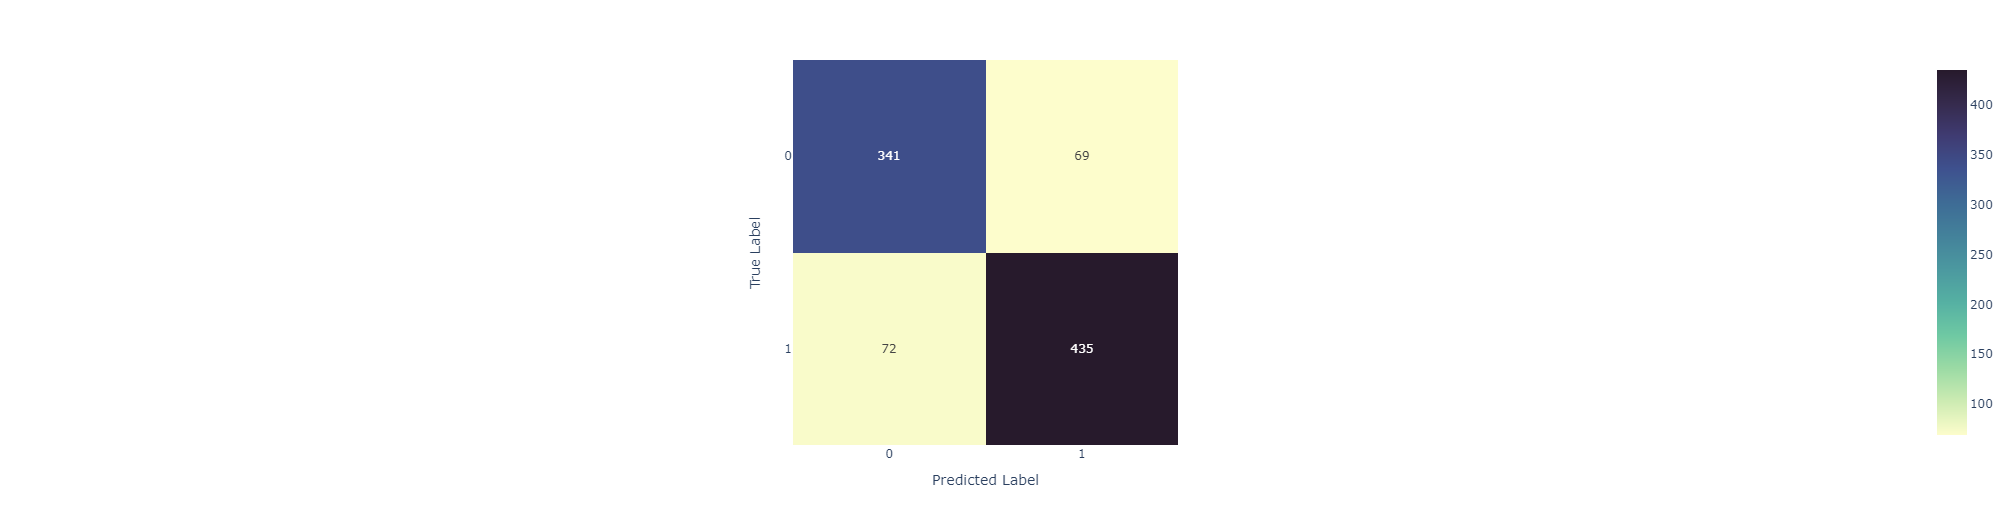

In [ ]:
def get_and_concat_results(results, grid_object, recall):
  temp_results = get_results(grid_object, recall)
  results = pd.concat([results, temp_results], axis=1)
  return results

XGBC produced better results than logistic regression. Results improved by 0.1% on accuracy and by 1.8% on recall. It's not that much of an improvment considering XGBC is significantly more complex than logistic regression

In [ ]:
results = get_and_concat_results(results, XGBC_grid_pipe, recall1)
results

,LogReg,XGBC
split0_test_score,88.043478,91.847826
split1_test_score,83.695652,85.869565
split2_test_score,86.338798,84.153005
split3_test_score,88.52459,84.153005
split4_test_score,75.956284,77.04918
mean_test_score,84.511761,84.614517
std_test_score,4.599481,4.723478
split0_recall_score,84.31,90.2
split1_recall_score,77.45,79.41
split2_recall_score,97.03,97.03


Now I'll try out SupportVectorClassifier 

In [ ]:
SVClassifier = SVC(random_state=78)

In [ ]:
pipe_svc = Pipeline([
                     ('transformer', ct_one_hot),
                     ('scaler', StandardScaler()),
                     ('imputer', imp),
                     ('SVC', SVClassifier)
])

In [ ]:
parameters = {
    'SVC__C':[0.01, 0.5, 1, 2, 4, 10],
    'SVC__kernel':['poly', 'rbf', 'sigmoid'],
    'SVC__degree':[2, 3, 4, 5],
    'SVC__gamma':['scale', 'auto'],
    'SVC__class_weight':['balanced', None]
}

In [ ]:
svc_grid_standard = GridSearchCV(pipe_svc, param_grid=parameters, scoring='accuracy', cv=5, verbose=2)

In [ ]:
svc_grid_standard.fit(X, y)

In [ ]:
svc_grid_standard.best_score_

0.8297754811119031

In [ ]:
svc_grid_standard.best_params_

{'SVC__C': 1,
 'SVC__class_weight': None,
 'SVC__degree': 2,
 'SVC__gamma': 'scale',
 'SVC__kernel': 'poly'}

In [ ]:
cm, recall = get_cm_and_recall(pipe_svc, svc_grid_standard.best_params_)

In [ ]:
fig = display_cm(cm)
fig.show()

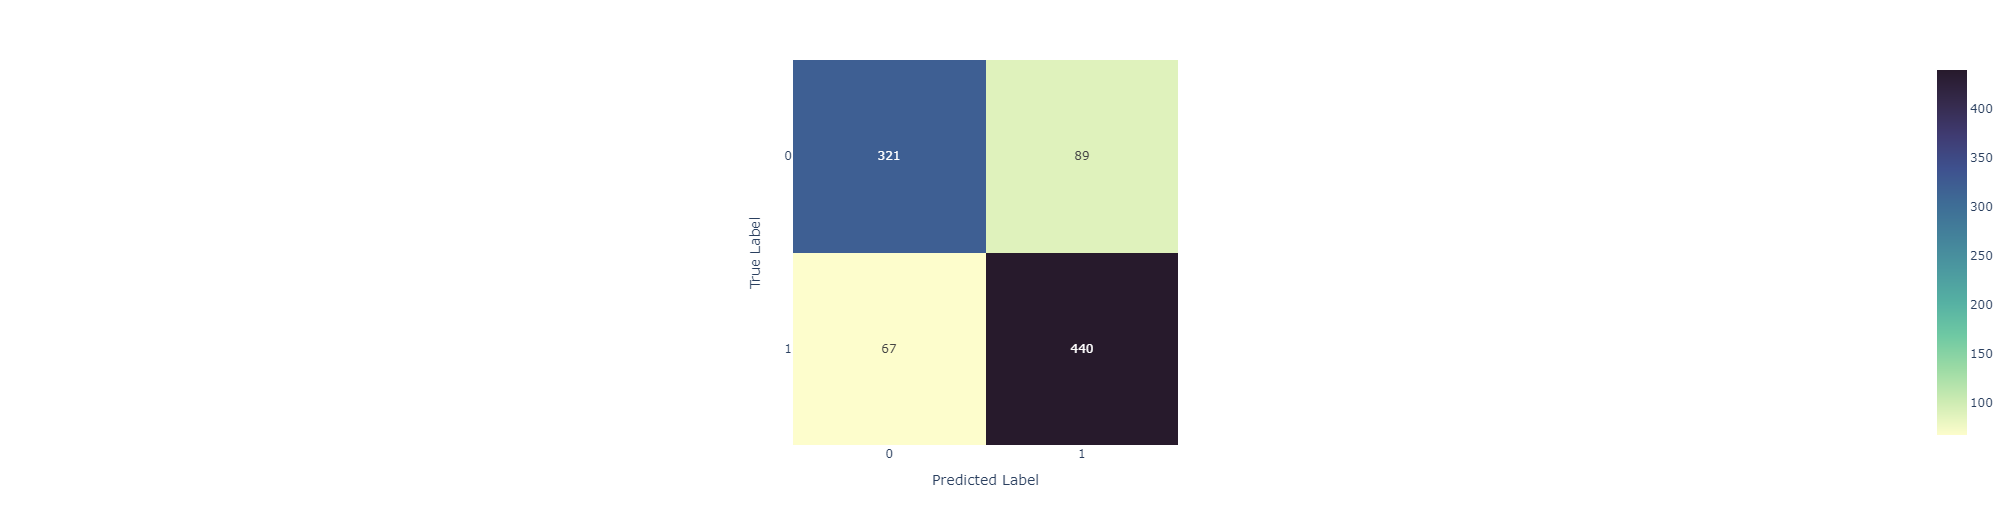

In [ ]:
recall

,0
split0_recall_score,90.20
split1_recall_score,79.41
split2_recall_score,96.04
split3_recall_score,91.09
split4_recall_score,77.23
mean_recall_score,86.79
std_recall_score,7.23


Support Vector Classifier scored lower on accuracy comparing to 2 previous kind of models but it improved on recall by 1% comparing to XGBR, it also has smaller standard deviation of recall calculated for different cv folds.

In [ ]:
results = get_and_concat_results(results, svc_grid_standard, recall)
results

,LogReg,XGBC,SVC
split0_test_score,88.043478,91.847826,91.304348
split1_test_score,83.695652,85.869565,84.23913
split2_test_score,86.338798,84.153005,82.513661
split3_test_score,88.52459,84.153005,81.420765
split4_test_score,75.956284,77.04918,75.409836
mean_test_score,84.511761,84.614517,82.977548
std_test_score,4.599481,4.723478,5.115393
split0_recall_score,84.31,90.2,90.2
split1_recall_score,77.45,79.41,79.41
split2_recall_score,97.03,97.03,96.04


Now let's try out KNN classifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn_pipe = Pipeline([
                     ('transformer', ct_one_hot),
                     ('scaler', StandardScaler()),
                     ('imputer', imp),
                     ('KNN', knn)
])

In [ ]:
parameters = {
    'KNN__n_neighbors':[2, 3, 4, 5, 7, 10, 15, 20, 30, 40],
    'KNN__weights':['uniform', 'distance'],
    'KNN__metric':['euclidean', 'manhattan', 'cosine']
}

In [ ]:
KNN_grid_pipe = GridSearchCV(knn_pipe, param_grid=parameters, cv=5, verbose=2, scoring='accuracy')

In [ ]:
KNN_grid_pipe.fit(X, y)

In [ ]:
KNN_grid_pipe.best_score_

0.851615585649798

In [ ]:
KNN_grid_pipe.best_params_

{'KNN__metric': 'manhattan', 'KNN__n_neighbors': 40, 'KNN__weights': 'uniform'}

In [ ]:
cm, recall = get_cm_and_recall(knn_pipe, KNN_grid_pipe.best_params_)

In [ ]:
fig = display_cm(cm)
fig.show()

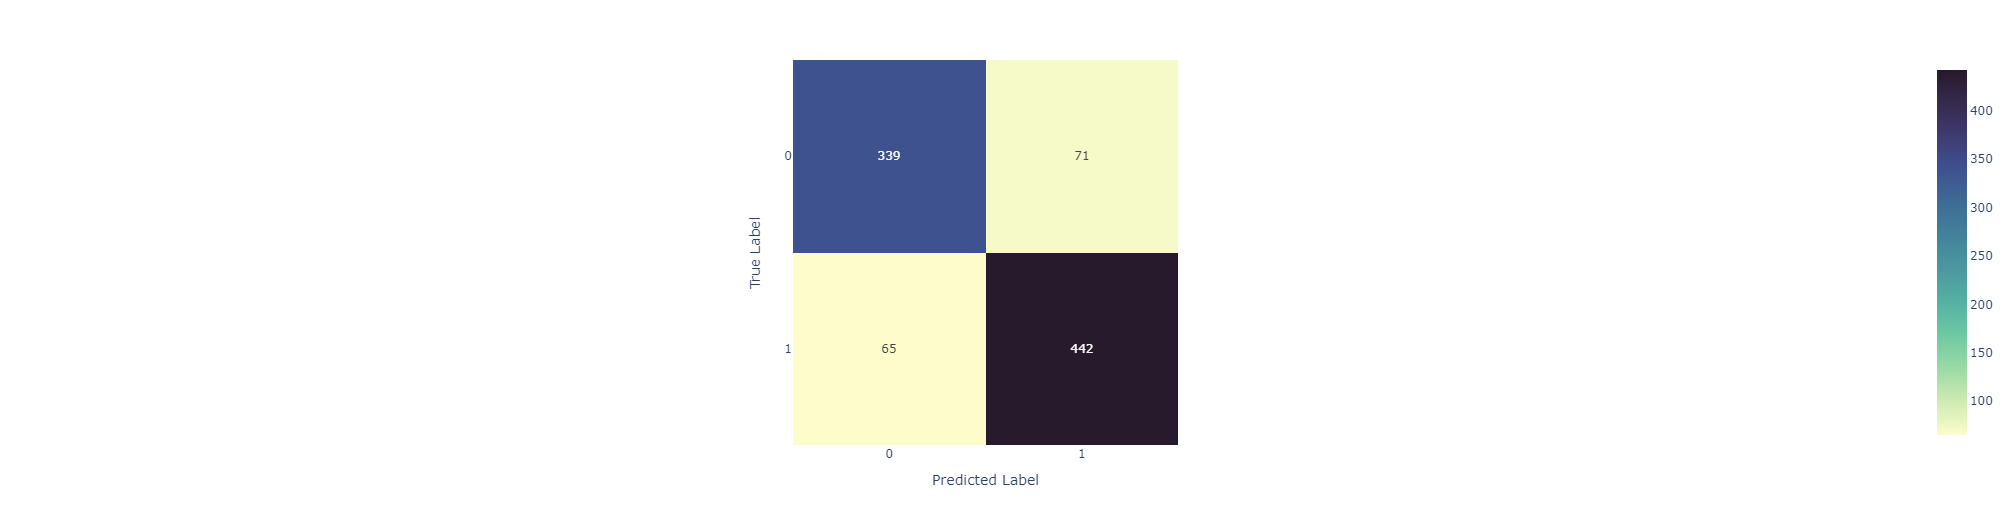

In [ ]:
results = get_and_concat_results(results, KNN_grid_pipe, recall)

So far KNN has produced the best results both on accuracy and recall. I'm going to do another round of gridsearch to try to score even better.

In [ ]:
results

,LogReg,XGBC,SVC,KNN
split0_test_score,88.043478,91.847826,91.304348,91.847826
split1_test_score,83.695652,85.869565,84.23913,85.326087
split2_test_score,86.338798,84.153005,82.513661,85.79235
split3_test_score,88.52459,84.153005,81.420765,85.79235
split4_test_score,75.956284,77.04918,75.409836,77.04918
mean_test_score,84.511761,84.614517,82.977548,85.161559
std_test_score,4.599481,4.723478,5.115393,4.718892
split0_recall_score,84.31,90.2,90.2,91.18
split1_recall_score,77.45,79.41,79.41,80.39
split2_recall_score,97.03,97.03,96.04,97.03


In [ ]:
parameters = {
    'KNN__n_neighbors':[32, 34, 36, 38, 40, 42, 44, 46, 48, 60, 80, 100],
    'KNN__weights':['uniform'],
    'KNN__metric':['manhattan']
}

In [ ]:
KNN_grid_pipe = GridSearchCV(knn_pipe, param_grid=parameters, cv=5, verbose=2, scoring='accuracy')

In [ ]:
KNN_grid_pipe.fit(X, y)

In [ ]:
KNN_grid_pipe.best_score_

0.8559871703492515

In [ ]:
KNN_grid_pipe.best_params_

{'KNN__metric': 'manhattan',
 'KNN__n_neighbors': 100,
 'KNN__weights': 'uniform'}

In [ ]:
cm, recall = get_cm_and_recall(knn_pipe, KNN_grid_pipe.best_params_)

In [ ]:
fig = display_cm(cm)
fig.show()

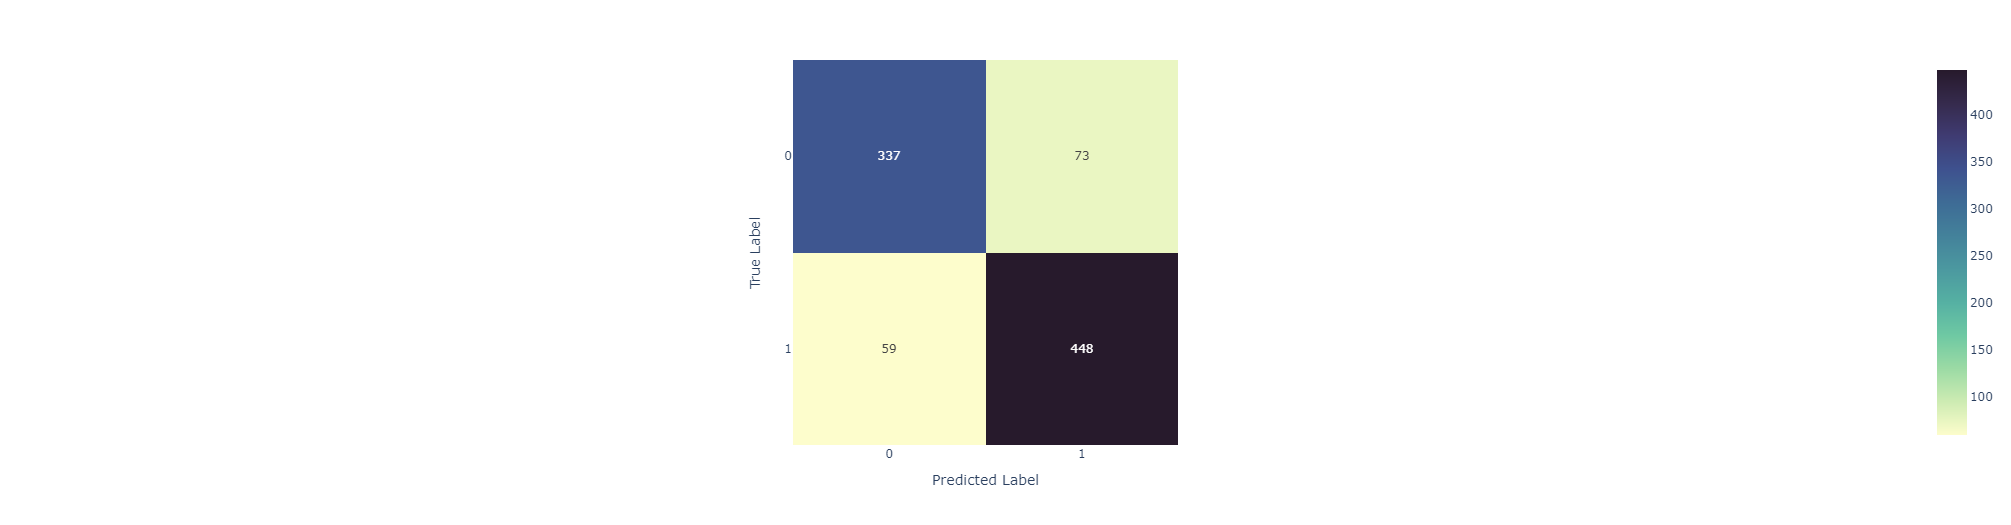

In [ ]:
parameters = {
    'KNN__n_neighbors':[90, 100, 110, 120],
    'KNN__weights':['uniform'],
    'KNN__metric':['manhattan']
}

In [ ]:
KNN_grid_pipe = GridSearchCV(knn_pipe, param_grid=parameters, cv=5, verbose=2, scoring='accuracy')

In [ ]:
KNN_grid_pipe.fit(X, y)

In [ ]:
KNN_grid_pipe.best_score_

0.8559871703492515

In [ ]:
KNN_grid_pipe.best_params_

{'KNN__metric': 'manhattan',
 'KNN__n_neighbors': 100,
 'KNN__weights': 'uniform'}

In [ ]:
cm, recall = get_cm_and_recall(knn_pipe, KNN_grid_pipe.best_params_)

In [ ]:
fig = display_cm(cm)
fig.show()

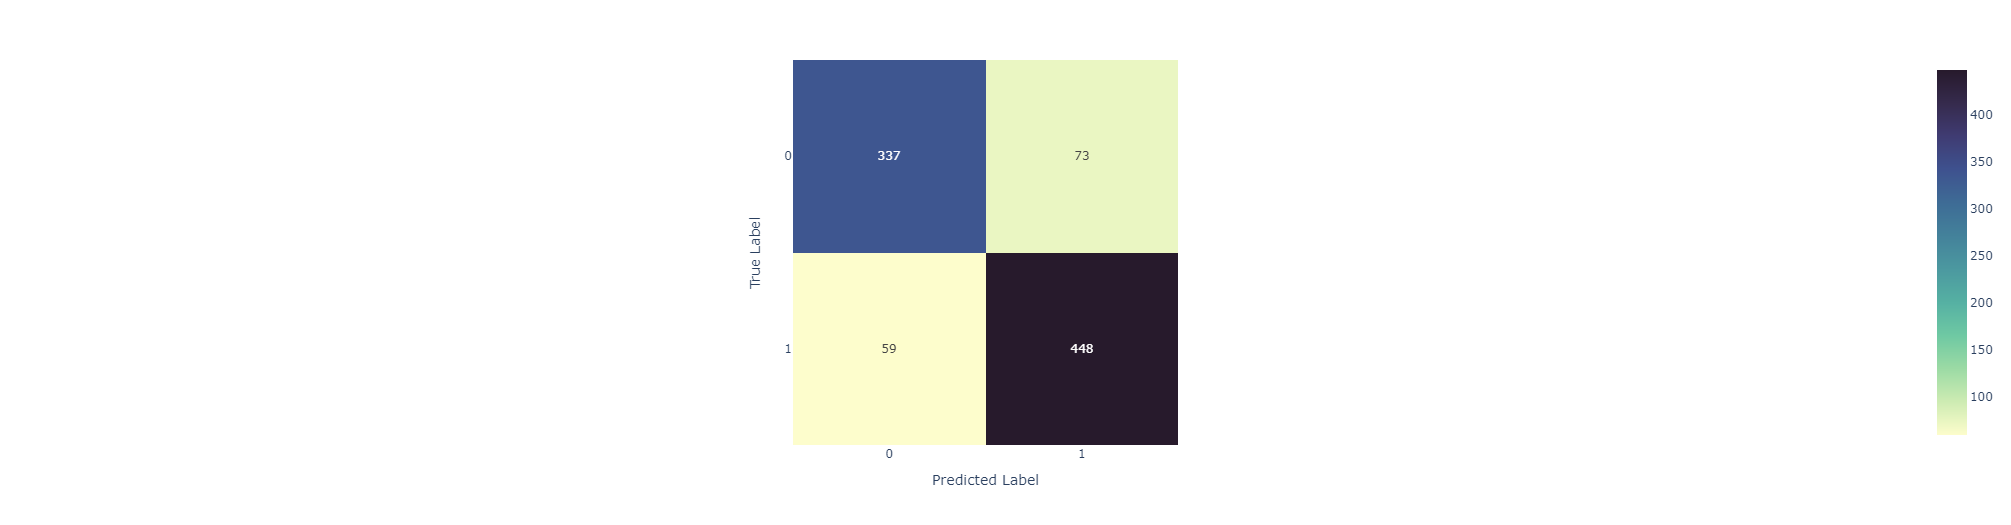

In [ ]:
results = results.drop('KNN', axis=1)

After 3 rounds of grid search K Nearest Neighbours managed to achieve mean accuracy of 85.6% with std of 3.7% and recall of 88.4% with std of 5.7%. These results are the best among all tested model types. I'm going to train KNN as an sklearn object instead of cuml and export it.

In [ ]:
results = get_and_concat_results(results, KNN_grid_pipe, recall)
results

,LogReg,XGBC,SVC,KNN
split0_test_score,88.043478,91.847826,91.304348,91.847826
split1_test_score,83.695652,85.869565,84.23913,85.326087
split2_test_score,86.338798,84.153005,82.513661,85.79235
split3_test_score,88.52459,84.153005,81.420765,84.699454
split4_test_score,75.956284,77.04918,75.409836,80.327869
mean_test_score,84.511761,84.614517,82.977548,85.598717
std_test_score,4.599481,4.723478,5.115393,3.681133
split0_recall_score,84.31,90.2,90.2,92.16
split1_recall_score,77.45,79.41,79.41,81.37
split2_recall_score,97.03,97.03,96.04,96.04


In [ ]:
KNN_grid_pipe.best_params_

{'KNN__metric': 'manhattan',
 'KNN__n_neighbors': 100,
 'KNN__weights': 'uniform'}

In [ ]:
knn = KNN_sk(metric='manhattan', n_neighbors=100, weights='uniform')
knn_pipe = Pipeline_sk([
                     ('transformer', ct_one_hot),
                     ('scaler', StandardScaler()),
                     ('imputer', imp),
                     ('KNN', knn)
])

In [ ]:
knn_pipe.fit(X, y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('scaler', StandardScaler()),
                ('imputer',
                 IterativeImputer(estimator=LinearRegression(), max_iter=20,
                                  tol=1e-07)),
                ('KNN',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=100))])

In [ ]:
joblib.dump(knn_pipe, '/content/drive/MyDrive/heart disease prediction/knn_pipeline.joblib')

['/content/drive/MyDrive/heart disease prediction/knn_pipeline.joblib']

In [ ]:
results.to_csv('/content/drive/MyDrive/heart disease prediction/results.csv', index=True)